## Import

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [100]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

In [101]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [102]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':10,
    'LEARNING_RATE':0.00005,
    'BATCH_SIZE':8,
    'SEED':41
}

## Fixed RandomSeed

In [103]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing
#### 1. Load Dataframe
#### 2. 결측치 보완
#### 3. Train / Validation Split
#### 4. Numeric Feature Scaling / Categorical Featrue Label-Encoding

In [104]:
train_df = pd.read_csv('/content/drive/MyDrive/medical/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/medical/test.csv')

In [105]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 1000 non-null   object 
 1   img_path           1000 non-null   object 
 2   mask_path          1000 non-null   object 
 3   나이                 1000 non-null   int64  
 4   수술연월일              1000 non-null   object 
 5   진단명                1000 non-null   int64  
 6   암의 위치              1000 non-null   int64  
 7   암의 개수              1000 non-null   int64  
 8   암의 장경              931 non-null    float64
 9   NG                 949 non-null    float64
 10  HG                 914 non-null    float64
 11  HG_score_1         908 non-null    float64
 12  HG_score_2         908 non-null    float64
 13  HG_score_3         911 non-null    float64
 14  DCIS_or_LCIS_여부    1000 non-null   int64  
 15  DCIS_or_LCIS_type  126 non-null    float64
 16  T_category         996 no

In [106]:
train_df.isnull().sum()

ID                     0
img_path               0
mask_path              0
나이                     0
수술연월일                  0
진단명                    0
암의 위치                  0
암의 개수                  0
암의 장경                 69
NG                    51
HG                    86
HG_score_1            92
HG_score_2            92
HG_score_3            89
DCIS_or_LCIS_여부        0
DCIS_or_LCIS_type    874
T_category             4
ER                     1
ER_Allred_score      297
PR                     1
PR_Allred_score      453
KI-67_LI_percent     235
HER2                  14
HER2_IHC              24
HER2_SISH            753
HER2_SISH_ratio      825
BRCA_mutation        945
N_category             0
dtype: int64

In [107]:
train_df['PR_Allred_score']

0      6.0
1      NaN
2      4.0
3      NaN
4      NaN
      ... 
995    NaN
996    NaN
997    NaN
998    NaN
999    2.0
Name: PR_Allred_score, Length: 1000, dtype: float64

In [108]:
train_df['암의 장경'] = train_df['암의 장경'].fillna(train_df['암의 장경'].mean())
train_df = train_df.fillna(0)

test_df['암의 장경'] = test_df['암의 장경'].fillna(train_df['암의 장경'].mean())
test_df = test_df.fillna(0)

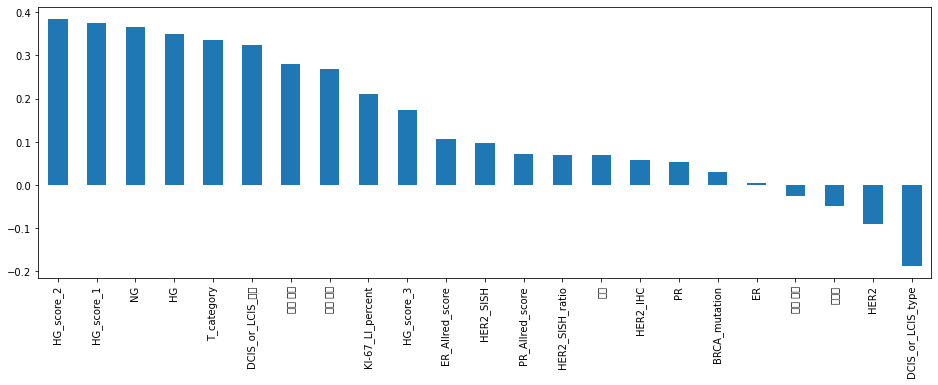

In [109]:
corr_matrix = train_df.corr()
corr = corr_matrix[train_df.columns[-1]].sort_values(ascending=False)[1:]
plt.rc('font', family='NanumBarunGothic') 
corr.plot.bar(figsize = (16, 5))

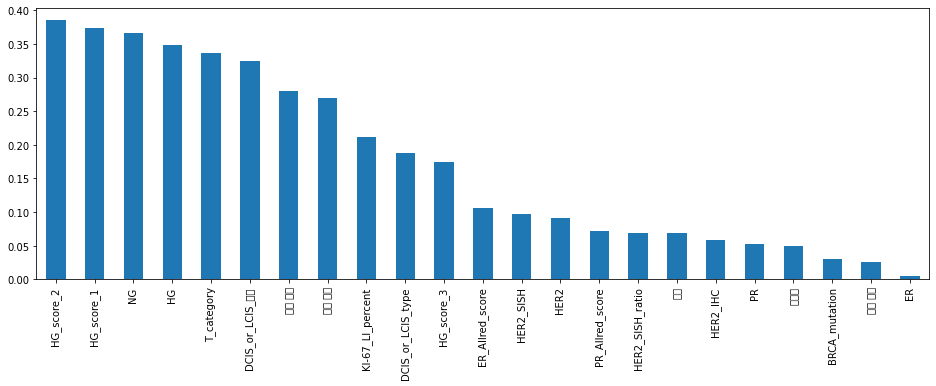

In [110]:
corr_matrix = train_df.corr()
corr = abs(corr_matrix[train_df.columns[-1]]).sort_values(ascending=False)[1:]
plt.rc('font', family='NanumBarunGothic') 
corr.plot.bar(figsize = (16, 5))

In [111]:
corr.values>0.25

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [112]:
corr.keys()

Index(['HG_score_2', 'HG_score_1', 'NG', 'HG', 'T_category', 'DCIS_or_LCIS_여부',
       '암의 장경', '암의 개수', 'KI-67_LI_percent', 'DCIS_or_LCIS_type', 'HG_score_3',
       'ER_Allred_score', 'HER2_SISH', 'HER2', 'PR_Allred_score',
       'HER2_SISH_ratio', '나이', 'HER2_IHC', 'PR', '진단명', 'BRCA_mutation',
       '암의 위치', 'ER'],
      dtype='object')

In [ ]:
train_df, val_df, train_labels, val_labels = train_test_split(
                                                    train_df.drop(columns=['N_category','암의 개수', 'KI-67_LI_percent', 'DCIS_or_LCIS_type', 'HG_score_3',
                                                    'ER_Allred_score', 'HER2_SISH', 'HER2', 'PR_Allred_score',
                                                    'HER2_SISH_ratio', '나이', 'HER2_IHC', 'PR', '진단명', 'BRCA_mutation',
                                                    '암의 위치', 'ER']), 
                                                    train_df['N_category'], 
                                                    test_size=0.2, 
                                                    random_state=CFG['SEED']
                                                )


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 976 to 960
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    object 
 1   img_path         800 non-null    object 
 2   mask_path        800 non-null    object 
 3   수술연월일            800 non-null    object 
 4   암의 장경            800 non-null    float64
 5   NG               800 non-null    float64
 6   HG               800 non-null    float64
 7   HG_score_1       800 non-null    float64
 8   HG_score_2       800 non-null    float64
 9   DCIS_or_LCIS_여부  800 non-null    int64  
 10  T_category       800 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 75.0+ KB


In [ ]:
def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']

for col in train_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        val_df[col] = scaler.transform(get_values(val_df[col]))
        test_df[col] = scaler.transform(get_values(test_df[col]))
    else:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(get_values(train_df[col]))
        val_df[col] = le.transform(get_values(val_df[col]))
        test_df[col] = le.transform(get_values(test_df[col]))

## CustomDataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, medical_df, labels, transforms=None):
        self.medical_df = medical_df
        self.transforms = transforms
        self.labels = labels
        
    def __getitem__(self, index):
        img_path = self.medical_df['img_path'].iloc[index]
        img_path='/content/drive/MyDrive/medical'+img_path[1:]
        
        image = cv2.imread(img_path)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
                
        if self.labels is not None:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일']).iloc[index])
            label = self.labels[index]
            return image, tabular, label
        else:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', '수술연월일']).iloc[index])
            return image, tabular
        
    def __len__(self):
        return len(self.medical_df)

In [ ]:
train_transforms = A.Compose([
                            A.HorizontalFlip(),
                            A.VerticalFlip(),
                            A.Rotate(limit=90, border_mode=cv2.BORDER_CONSTANT,p=0.3),
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transforms = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [ ]:
train_dataset = CustomDataset(train_df, train_labels.values, train_transforms)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_df, val_labels.values, test_transforms)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
a,b,c=next(iter(train_loader))

In [ ]:
a.shape

torch.Size([8, 3, 512, 512])

## Model Architecture

In [ ]:
class ImgFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImgFeatureExtractor, self).__init__()
        self.backbone = models.efficientnet_v2_m(pretrained=True)
        self.embedding = nn.Linear(1000,512)
        self.embedding1 = nn.Linear(512,256)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        x = self.embedding1(x)
        return x

In [ ]:
class TabularFeatureExtractor(nn.Module):
    def __init__(self):
        super(TabularFeatureExtractor, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(in_features=7, out_features=128),
            
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=256),
           
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=512),
           
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=256),
            
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=256),
            
            nn.LeakyReLU()
      
        )
        
    def forward(self, x):
        x = self.embedding(x)
        return x

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.img_feature_extractor = ImgFeatureExtractor()
        self.tabular_feature_extractor = TabularFeatureExtractor()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=1),
            nn.Sigmoid(),
        )
        
    def forward(self, img, tabular):
        img_feature = self.img_feature_extractor(img)
        tabular_feature = self.tabular_feature_extractor(tabular)
        feature = torch.cat([img_feature, tabular_feature], dim=-1)
        output = self.classifier(feature)
        return output

## Train

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for img, tabular, label in tqdm(iter(train_loader)):
            img = img.float().to(device)
            tabular = tabular.float().to(device)
            label = label.float().to(device)
            
            optimizer.zero_grad()
            
            model_pred = model(img, tabular)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_score = validation(model, criterion, val_loader, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
        
        if best_score < val_score:
            best_score = val_score
            best_model = model
    
    return best_model

In [ ]:
def validation(model, criterion, val_loader, device):
    model.eval()
    pred_labels = []
    true_labels = []
    val_loss = []
    threshold = 0.5
    with torch.no_grad():
        for img, tabular, label in tqdm(iter(val_loader)):
            true_labels += label.tolist()
            
            img = img.float().to(device)
            tabular = tabular.float().to(device)
            label = label.float().to(device)
            
            model_pred = model(img, tabular)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            val_loss.append(loss.item())
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
    
    pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
    val_score = metrics.f1_score(y_true=true_labels, y_pred=pred_labels, average='macro')
    return np.mean(val_loss), val_score

In [ ]:
# import torch, gc
# gc.collect()
# torch.cuda.empty_cache()

## Run!!

In [ ]:
model = nn.DataParallel(ClassificationModel())
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.67397] Val Loss : [0.63943] Val Score : [0.69484]


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.65023] Val Loss : [0.64039] Val Score : [0.66348]


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.63732] Val Loss : [0.62568] Val Score : [0.69866]


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.63051] Val Loss : [0.63147] Val Score : [0.71771]


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.60351] Val Loss : [0.61817] Val Score : [0.74216]


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.60250] Val Loss : [0.62208] Val Score : [0.73833]


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.59570] Val Loss : [0.61631] Val Score : [0.74095]
Epoch 00007: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

## Inference

In [ ]:
test_df=test_df.drop(['암의 개수', 'KI-67_LI_percent', 'DCIS_or_LCIS_type', 'HG_score_3',
       'ER_Allred_score', 'HER2_SISH', 'HER2', 'PR_Allred_score',
       'HER2_SISH_ratio', '나이', 'HER2_IHC', 'PR', '진단명', 'BRCA_mutation',
       '암의 위치', 'ER'])

In [ ]:
test_df

In [ ]:
test_dataset = CustomDataset(test_df, None, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    threshold = 0.5
    
    with torch.no_grad():
        for img, tabular in tqdm(iter(test_loader)):
            img = img.float().to(device)
            tabular = tabular.float().to(device)
            
            model_pred = model(img, tabular)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            
            preds += model_pred.tolist()
    
    preds = np.where(np.array(preds) > threshold, 1, 0)
    
    return preds

In [ ]:
a,b=next(iter(test_loader))

In [ ]:
a.shape

In [ ]:
preds = inference(infer_model, test_loader, device)

## Submission

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/medical/sample_submission.csv')

In [ ]:
submit['N_category'] = preds
submit.to_csv('/content/drive/MyDrive/medical/submit.csv', index=False)